# Kilonova Class

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
import random
import itertools
import time
from scipy.constants import k
from astropy.table import Table, Column, vstack
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from scipy.interpolate import interp1d
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, MaxNLocator, AutoLocator
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline

## Kilonova

In [2]:
class kilonova(object):
    
    def __init__(self, merger, name):
        '''
        A Merger is a table of varying magnitudes representing a kilonova light curve in five different
        filters (u, g, r, i, z).
        A Name is a string representing the theoretical kilonova light curve's object ID.
        Results are different information about the kilonova (e.g. light curves, discovery metrics, etc.).
        
        kilonova: Merger Name -> Results
        
        This class takes in a kilonova with an object id and runs different tests on the kilonova
        (e.g. light curves, discovery metrics, etc.).
        '''
    
        self.merger = merger
        self.name = name

#___________________________________________________________________________________________________________

#
#
# CONSTANTS, APPARENT MAGNITUDE CALCULATIONS, AND KILONOVA LIGHT CURVES
#
#


#
# CONSTANTS:
#

    
# Discovery Metrics
    '''
    DEFINITIONS:
    sigma_sys: the systematic error of the LSST
    trial_num: the number of trials in the simulations for the discovery metrics
    t_vis: the visibility time of the LSST
    parameters: table representing different conditions of the LSST for each of the five filters
    '''
    sigma_sys = 0.005
    trial_num = 1000
    bands = ['u','g','r','i','z']
    t_vis = 30
    parameters = Table([['m_sky', 'theta', 'gamma', 'k_m', 'C_m', 'm_5', 'del_C', 'del_C2', 'del_m_5'],
                        [22.9, 0.77, 0.037, 0.451, 22.92, 23.68, 0.67, 0.24, 0.21],
                        [22.3, 0.73, 0.038, 0.163, 24.29, 24.89, 0.21, 0.09, 0.15],
                        [21.2, 0.70, 0.039, 0.087, 24.33, 24.43, 0.11, 0.05, 0.14],
                        [20.5, 0.67, 0.039, 0.065, 24.20, 24.00, 0.08, 0.04, 0.13], 
                        [19.6, 0.65, 0.040, 0.043, 24.07, 24.45, 0.05, 0.03, 0.13],
                        [18.6, 0.63, 0.040, 0.138, 23.69, 22.60, 0.04, 0.02, 0.15,]],
                      names = ('parameters','u', 'g', 'r', 'i', 'z', 'y'))
    
    
# Light Curve Constants
    '''
    DEFINITIONS:
    title: the font size for the title of a graph
    subtitle: the font size for the subtitle of a graph
    axis: the font size for the axis of a graph
    ticksize: the size for the axis ticks of a graph
    legend: the font size for the legend of a graph
    '''
    title = 26
    subtitle = 24
    axis = 20
    ticksize = 14
    legend = 14


    
#
# APPARENT MAGNITUDE CALCULATIONS
#
    '''
    DEFINITIONS:
    A Distance is a Number that is measured in Mpc.
    A Redshift is a Number indicating the distance of an object by how much the light of the object has
    redshifted.
    A Magnitude is a Number indicating the brightness of an object measured on earth.
    A Band is a String; each band represents the specific filter that LSST will use (u,z,r,i,z,y).
    '''


# Megaparsecs

    def app_mag_dist(self, distance):
        '''
        app_mag: Merger Distance -> Merger
        Converts the merger data from absolute magnitude to apparent magnitude depending on the distance 
        (Mpc).
        '''
        self.distance = distance
        day=self.merger['day']
        u=self.app_mag_band_dist('u')
        g=self.app_mag_band_dist('g')
        r=self.app_mag_band_dist('r')
        i=self.app_mag_band_dist('i')
        z=self.app_mag_band_dist('z')
        return Table([day, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))


    def app_mag_band_dist(self, band):
        '''
        app_mag_band: Magnitude Distance String -> Magnitude
        Converts the absolute magnitude into an apparent magnitude depending on the distance and the band 
        filter.
        '''
        self.band = band
        app_mag = 5*np.log10((self.distance*1e6)/10)+self.merger[self.band]
        return app_mag


# Redshift

    def app_mag_redshift(self, redshift):
        '''
        app_mag_redshift: Merger Number -> Merger
        Converts the merger data from absolute magnitude to apparent magnitude depending on the redshift.
        '''
        self.redshift = redshift
        day=self.merger['day']
        u=self.app_mag_band_redshift('u')
        g=self.app_mag_band_redshift('g')
        r=self.app_mag_band_redshift('r')
        i=self.app_mag_band_redshift('i')
        z=self.app_mag_band_redshift('z')
        return Table([day, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))

    
    def app_mag_band_redshift(self, band):
        '''
        app_mag_band: Magnitude Redshift Band -> Magnitude
        Converts the absolute magnitude into an apparent magnitude dpending on the redshift and the band 
        filter.
        '''
        self.band = band
        app_mag = 5*np.log10(self.lumo_dist()/10)+self.merger[self.band]
        return app_mag


    def lumo_dist(self):
        '''
        lumo_dist: Reshift -> Distance
        Converts redshift to luminosity distance.
        '''
        return cosmo.luminosity_distance(self.redshift).to(astro.units.pc).value

    
    


#    
# KILONOVA LIGHT CURVES
#

    majorLocator = MultipleLocator(1)
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(0.25)


    def band_plot_rand(self):
        X = random.random()+1
        merger_new = self.rand_mags(X)
        
        
        x = (merger_new['day']/merger_new['day'])-1
        LSST_u=x+self.m_5('u', self.parameters, X, self.t_vis)
        LSST_g=x+self.m_5('g', self.parameters, X, self.t_vis)
        LSST_r=x+self.m_5('r', self.parameters, X, self.t_vis)
        LSST_i=x+self.m_5('i', self.parameters, X, self.t_vis)
        LSST_z=x+self.m_5('z', self.parameters, X, self.t_vis)
        fig=plt.figure(figsize=(12,30))
        for band in self.bands:
            if band == 'u':
                self.band_graph_rand(merger_new, 'u', 'b', 511, 0, LSST_u, X)
            elif band == 'g':
                self.band_graph_rand(merger_new, 'g', 'g', 512, 1, LSST_g, X)
            elif band == 'r':
                self.band_graph_rand(merger_new, 'r', 'y', 513, 2, LSST_r, X)
            elif band == 'i':
                self.band_graph_rand(merger_new, 'i', 'orange', 514, 3, LSST_i, X)
            elif band == 'z':
                self.band_graph_rand(merger_new, 'z', 'r', 515, 4, LSST_z, X)
        plt.suptitle("Light Curve Bands of " + self.name, fontsize=self.title, y=1.01)
        plt.tight_layout()
        return

    def band_graph_rand(self, merger_new, band, color, sub_num, num, LSST_band, X):
        ax = plt.subplot(sub_num)
        l1 = self.plot_band_rand(merger_new, band, '.', color, X)
        l2 = self.plot_interp(merger_new, band, '-', color, num, X)
        l3 = plt.plot(merger_new['day'], LSST_band, color, label='LSST (' + band + ')')
        l4 = self.plot_band_limits(merger_new, band, 'none', color, X)
        plt.xlim(0,self.uplim(merger_new, band, X)['lim days'][0]+0.1)
        plt.ylim(self.m_5(band, self.parameters, X, self.t_vis)+0.1,
                 (self.correct_min_band(merger_new, band)-0.1))
        plt.xlabel("Time (Days)", fontsize=self.axis)
        plt.ylabel('Magnitude', fontsize=self.axis)
        ax.tick_params(labelsize=self.ticksize)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':self.legend})
        return

    #plot_band: Merger String String String -> Image
    #Plots the magnitudes of a photometric band in the merger.
    def plot_band_rand(self, merger_new, band, style, color, X):
        upperlimits = self.uplim(merger_new, band, X)
        plt.errorbar(upperlimits['reg days'], upperlimits['regular'],
                     yerr=self.sigmas(upperlimits['regular'], band, X, self.t_vis), fmt=style,
                     color=color, markeredgecolor='black', markersize=7, capsize = 5, elinewidth = 2,
                     label=self.produce_label(upperlimits['regular'], band))
        return

    def plot_band_limits(self, merger_new, band, style, color, X):
        upperlimits = self.uplim(merger_new, band, X)
        plt.errorbar(upperlimits['lim days'], upperlimits['limits'],
                     yerr=self.sigma_1(self.m_5(band, self.parameters, X, self.t_vis), band, X, self.t_vis),
                     fmt=style, uplims=True, color=color, markeredgecolor='black', capsize = 5)
        return
    
    
    #plot_interp: Merger String String String Number -> Image
    #Plots the interpolation of a photometric band in the merger.
    def plot_interp(self, merger, name, style, color, number, X):
        new_days = self.day_new(merger, name)
        plt.plot(new_days, self.interpolate(merger, X, self.t_vis)[number](new_days),
                 style, color=color, label=name+' interp.')
        return
    
    
    #day_new Merger String -> List of Numbers
    #Produces a new set of points between the range of the 'day' column in the merger data. 
    # This is useful for plotting the interpolations.

    def day_new(self, merger, band):
        set_length=100
        day_new = np.linspace(min(merger['day'][np.isfinite(merger[band])]),
                              max(merger['day'][np.isfinite(merger[band])]),set_length)
        return day_new


    def uplim(self, merger, band, X):
        limits=[]
        regular=[]
        lim_days=[]
        reg_days=[]
        m_5 = self.m_5(band, self.parameters, X, self.t_vis)
        for mag in merger[band]:
            if mag == m_5:
                limits.append(mag)
            else:
                regular.append(mag)
                reg_days.append(np.float(merger[np.where(merger[band] == mag)]['day']))

        y = np.array(merger[np.where(merger[band] == m_5)]['day'])

        for x in y:
            lim_days.append(x)

        return {'regular': regular, 'limits': limits, 'reg days': reg_days, 'lim days': lim_days}

    def produce_label(self, lim_list, band):
        if len(lim_list) == 0:
            label = None
        else:
            label = band
        return label

    def correct_min_band(self, merger, band):
        minimum = min(merger[band][np.isfinite(merger[band])])
        return minimum
    
    
    def rand_mags(self, X):
        u = []
        g = []
        r = []
        i = []
        z = []
        
        merger = self.app_mag_dist(self.rand_dist())
        days = np.array(self.merger['day'])
        
        for day in days:
            u.append(self.rand_mag(merger, 'u', day, 0, X, self.t_vis))        
            g.append(self.rand_mag(merger, 'g', day, 1, X, self.t_vis))        
            r.append(self.rand_mag(merger, 'r', day, 2, X, self.t_vis))       
            i.append(self.rand_mag(merger, 'i', day, 3, X, self.t_vis))       
            z.append(self.rand_mag(merger, 'z', day, 4, X, self.t_vis))
        return Table([days, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))
    
    def sigmas(self, mags, band, X=1, t_vis=30):
        sigmas = []
        for mag in mags:
            sigmas.append(self.sigma_1(mag, band, X, t_vis))
        return sigmas

#-----------------------------------------------------------------------------------------------------------

#
# Additional Functions
#
 
    '''
    DEFINITIONS:
    LSST is a dictionary giving the 5-sigma depths of the telescope in specific bands. Each Number in the
    dictionary represents the deepest magnitude LSST can see. LSST depends on specific parameters of 
    telescope (regarding the m_5 depth of the telescope) as well as the visibility time (t_vis).
    A Magnitude is a Number that indicates the apparent brightness of the star measured from the telescope.
    X is a Number that represents the airmass that LSST looks through.
    '''    
    
    
# Weather:

    def weather_simulator(self, time):
        
        '''
        weather_simulator: Dummy_Variable -> Time
        
        weather_simulator is a random probability generator with the following probability: 80% of 
        'clear skies' and 20% of 'cloudy weather.' If the weather is cloudy, the Epoch is adjusted 24 hrs
        later and tested again until there are clear skies again.
        '''
        weather = random.random()
        if weather < 0.8:
            time = time
        else:
            time = self.weather_simulator(time+1)
        return time
    
# Airmass:
    
    def rand_X(self):
        '''
        rand_X: Dummy_Variable -> Airmass
        
        Calculates a list of random Airmasses from 1 to 2.
        '''
        airmasses = []
        for i in range(self.trial_num):
            airmass = random.random()+1
            airmasses.append(airmass)
        
        return airmasses

# Distances:

    def rand_dists(self):
        '''
        rand_dists: Dummy_Variable -> Distances
        
        Calculates a list of random distances from 0 to 200Mpc.
        '''
        distances = []
        for i in range(self.trial_num):
            distances.append(self.rand_dist())
        return distances

    #rand_dist: Merger -> Number
    #Picks a random distance from 0 to 200Mpc.
    def rand_dist(self):
        '''
        rand_dist: Dummy_Variable -> Distance
        
        Calculates a random distance from 0 to 200Mpc.
        '''
        x=random.uniform(-1,1)
        y=random.uniform(-1,1)
        z=random.uniform(-1,1)
        dist=np.sqrt(x**2+y**2+z**2)
        if dist <= 1:
            return dist*200
        else:
            return self.rand_dist()
        return

    
# Magnitude Calculations:    
    
    def get_mag(self, merger, band, time, LSST, X=1, t_vis=30):
        '''
        get_mag: Merger Band Time LSST X t_vis -> Magnitude
        
        Calculates a random magnitude of the kilonova in a specific filter and time under specific 
        parameters listed in the function.
        '''
        mag=0
        if self.detect(merger, band, time, LSST, X, t_vis)==True:
            if band == 'u':
                mag = self.rand_mag(merger, band, time, 0, X, self.t_vis)
            elif band == 'g':
                mag = self.rand_mag(merger, band, time, 1, X, self.t_vis)
            elif band == 'r':
                mag = self.rand_mag(merger, band, time, 2, X, self.t_vis)
            elif band == 'i':
                mag = self.rand_mag(merger, band, time, 3, X, self.t_vis)
            elif band == 'z':
                mag = self.rand_mag(merger, band, time, 4, X, self.t_vis)

        elif self.detect(merger, band, time, LSST, X, self.t_vis)==False:
            mag = LSST[band]

        return mag
    
    
    #detect: Merger String Number -> Boolean
    #Determines if LSST can detect the light curve of a specific band at a specific time.
    def detect(self, merger, band, time, LSST, X=1, t_vis=30):
        '''
        detect: Merger Band Time LSST X t_vis -> Boolean
        
        Indicates whether or not LSST can actually see the kilonova source.
        '''
        if band == 'u':
            mag_u = self.rand_mag(merger, band, time, 0, X, t_vis)
            return self.in_view(mag_u, LSST['u'])
        elif band == 'g':
            mag_g = self.rand_mag(merger, band, time, 1, X, t_vis)
            return self.in_view(mag_g, LSST['g'])
        elif band == 'r':
            mag_r = self.rand_mag(merger, band, time, 2, X, t_vis)
            return self.in_view(mag_r, LSST['r'])
        elif band == 'i':
            mag_i = self.rand_mag(merger, band, time, 3, X, t_vis)
            return self.in_view(mag_i, LSST['i'])
        elif band == 'z':
            mag_z = self.rand_mag(merger, band, time, 4, X, t_vis)
            return self.in_view(mag_z, LSST['z'])
        return
    
    
    #in_view: Number Number -> Boolean
    #Checks if LSST can detect the light curve based on magnitude.
    def in_view(self, mag, LSST):
        '''
        in_view: Magnitude Magnitude -> Boolean
        
        Indicates if the magnitude measured is smaller (the source is brighter) than the LSST's 5-sigma
        magnitude.
        '''
        if mag < LSST:
            return True
        else:
            return False
        return
    
    
    def rand_mag(self, merger, band, time, number, X=1, t_vis=30):
        '''
        rand_mag: Merger Band Time Number X t_vis -> Magnitude
        
        Calculates a random magnitude from a gaussian distributed probability generator with the average
        magnitude as the expected magnitude on the light curve and the standard deviation is the sigma_1
        standard deviation (explained later in sigma_1 function).
        '''
        max_depth = self.m_5(band, self.parameters, X, t_vis)
        if self.interpolate(merger, X, t_vis)[number](time) > max_depth:
            m_true = max_depth

        else:
            m_true = self.interpolate(merger, X, t_vis)[number](time)

        stdev = self.sigma_1(m_true, band)        

        if m_true == max_depth:
            m_obs = max_depth
        else:
            m_obs = np.random.normal(m_true, stdev)
        return m_obs
    

    #interpolate: Merger-> List of Interpolations
    #Provides the necessary interpolation functions of the mergers in each associated photometric bands. 
    def interpolate(self, merger, X=1, t_vis=30):
        '''
        interpolate: Merger X t_vis -> Magnitude
        
        Calculates the theoretical magnitude of a kilonova based on our light curves. Our light curves are
        cubic-splined interpolations of theoretical data created by the Tanaka Papers.
        '''
        LSST_u=self.m_5('u', self.parameters, X, self.t_vis)
        LSST_g=self.m_5('g', self.parameters, X, self.t_vis)
        LSST_r=self.m_5('r', self.parameters, X, self.t_vis)
        LSST_i=self.m_5('i', self.parameters, X, self.t_vis)
        LSST_z=self.m_5('z', self.parameters, X, self.t_vis)
        approx='cubic'
        u=interp1d(merger['day'][np.isfinite(merger['u'])], merger['u'][np.isfinite(merger['u'])],
                   kind=approx, bounds_error=False, fill_value=LSST_u)
        g=interp1d(merger['day'][np.isfinite(merger['g'])], merger['g'][np.isfinite(merger['g'])],
                   kind=approx, bounds_error=False, fill_value=LSST_g)
        r=interp1d(merger['day'][np.isfinite(merger['r'])], merger['r'][np.isfinite(merger['r'])],
                   kind=approx, bounds_error=False, fill_value=LSST_r)
        i=interp1d(merger['day'][np.isfinite(merger['i'])], merger['i'][np.isfinite(merger['i'])],
                   kind=approx, bounds_error=False, fill_value=LSST_i)
        z=interp1d(merger['day'][np.isfinite(merger['z'])], merger['z'][np.isfinite(merger['z'])],
                   kind=approx, bounds_error=False, fill_value=LSST_z)
        return [u, g, r, i, z]
    
    
    
# Sigma Calculation:
    '''
    DEFINITIONS:
    A Std_Dev is a number representing a standard deviation.
    Parameters is the table of values listed at the top of the code in the CONSTANTS section (see Ivzic 
    paper on LSST, pg. 20, for details about the table)
    '''
    
    def sigma_1(self, mag, band, X=1, t_vis=30):
        '''
        sigma_1: Magnitude Band X t_vis -> Std_Dev
        
        Calculates the sigma_1 standard deviation of a magnitude on our kilonova light curve. Sigma_1 is the 
        photometric error for a single visit in the sky by LSST. The standard deviation depends on both
        systematic and random photometric error. Since LSST is not built yet we are assuming the systematic
        error is 0.005 magnitude.
        '''
        sigma1=np.float(np.sqrt(self.sigma_sys**2+self.sigma_rand(mag, band, self.parameters, X, t_vis)**2))
        return sigma1


    def sigma_rand(self, mag, band, parameters, X=1, t_vis=30):
        '''
        sigma_rand: Magnitude Band Parameters X t_vis -> Std_Dev
        
        Calculates the random photometric error of LSST for a Magnitude in a choosen filter.
        '''
        gamma = parameters[band][np.where(parameters['parameters']=='gamma')]
        return np.float((0.04-gamma)*self.x(mag, band, parameters, X, t_vis) + gamma*self.x(mag, 
                                                                                            band, 
                                                                                            parameters, 
                                                                                            X, t_vis)**2)

    def x(self, mag, band, parameters, X=1, t_vis=30):
        '''
        x: Magnitude Band Parameters X t_vis -> Number
        
        Additional step in calculating the random photometric error.
        '''
        return np.float(10**(0.4*(mag-self.m_5(band, parameters, X, t_vis))))

    
    def m_5(self, band, parameters, X=1, t_vis=30):
        '''
        m_5: Band Parameters X t_vis -> Magnitude
        
        Calculates the 5-sigma depth of LSST in a particular filter. The 5-sigma depth is essentially the
        maximum depth LSST can see before the signal-to-noise ratio becomes to large to accurately measure 
        the magnitude of a kilonova.
        '''
        C_m = parameters[band][np.where(parameters['parameters']=='C_m')]
        m_sky = parameters[band][np.where(parameters['parameters']=='m_sky')]
        theta = parameters[band][np.where(parameters['parameters']=='theta')]
        k_m = parameters[band][np.where(parameters['parameters']=='k_m')]
        m_5 = C_m+0.50*(m_sky-21)+2.5*np.log10(0.7/theta)+1.25*np.log10(t_vis/30)-k_m*(X-1)
        return np.float(m_5)
    
#___________________________________________________________________________________________________________
    
    




## LSST DISCOVERY METRICS & CALCULATIONS

In [3]:
#
#
# LSST DISCOVERY METRICS & CALCULATIONS
#    
#  

'''
DEFINITIONS:
A Kilonova is a (Merger, Name). Both Merger and Name in Kilonova will be used independently
   in certain functions.

A Discovery_Metric is a table with three different columns: band filters, distances (Mpc) of the kilonova,
    and a discovery column of the discovery metric that LSST ran on the kilonova 
    (0 = no discovery; 1 = discovery).

NOTE: A Discovery_Metric can be one of three options:
        - 1-Day_Discovery_Metric
        - 3-Day_Discovery_Metric
        - 7-Day_Discovery_Metric
'''

class discovery_metrics(kilonova):
    
    def __init__(self, kilonova):
        '''
        discovery_metrics: Kilonova -> Discovery_Metric
    
        This class takes in a kilonova with an object id and runs basic discovery metrics that we would 
        expect LSST to use to discover kilonovae.
        '''
        self.merger = kilonova.merger
        
    
#
# Discovery Metrics
#

    '''
    The discovery metrics we are using are simple criteria used to simulate what LSST would use to discover 
    kilonovae in the sky. The metrics use two major characteristics of kilonovae--short visibility time and 
    low temperature explosion--to distiguish them from other transient sources. These metrics use change in
    magnitude (difference in magnitude of a single band at different time periods, denoted "del-mag")
    and color (difference in magnitude between two bands at a single time, denoted "f-z" where f is all 
    bands except for z) to run simple "discovery metric criteria" of what we believe to be the optimal way 
    to discover a kilonova. Right now the metrics are quite simple, but in the future we will work to make 
    the tests more complex and realistic to what the telescope will face in Chile.

    Each discovery metric have the following assumptions:
    - Maximum of 4 observations by LSST.
    - First observation happens at a random time in a 24-hour period (Epoch 1).
    - If LSST cannot observe due to bad weather (20% probability), then it will observe 24 hours later.
    - The farther away the kilonova is, the harder it is for LSST to detect it.
    '''

    '''
    DEFINITIONS:
    Dummy_Variable is a filler input that does not comtribute to the calculations of a function.
    Times is a list of numbers representing days at which LSST observes a kilonova.
    Distances is a list of numbers representing distances from 0 to 200Mpc.
    Colors is a list of colors (f-z) measured at different times and distances.
    Time is a Number.
    '''

# 1-day Discovery Metric (1-day)

    def one_day(self):
        '''
        one_day: Kilonova -> 1-Day_Discovery_Metric

        Note: A 1-day discovery metric is a table that provides the band that LSST is using, the distance at
        which a simulated kilonova takes place, and a binary result that shows if LSST detects it
        (i.e., 0 = no detection; 1 = detection).
        
        
        The 1-day discovery metric has the following criteria:
        
        NOTE: 
        - del-mag = Epoch 2 - Epoch 1
        - f-z is the color measure in the same epoch
        
        
        IN ORDER FOR LSST TO MAKE A DISCOVERY:
        
        For Epoch 1:
            - f-z > 0.5 with signal-to-noise > 3
        
        For Epoch 2 (Epoch 1 + 1 Day):
            - f-z > 0.5 with signal-to-noise > 3
            - del-mag of z-band > 0.5 with signal-to-noise > 3
        
        OR
        
        For Epoch 1:
            - f-z < -0.5 with a signal-to-noise > 3:
        
        For Epoch 2 (Epoch 1 + 1 Day):
            - f-z > 1 with signal-to-noise > 3
            - del-mag of z-band < 0.2 with signal-to-noise > 3
        '''
        
        time = self.weather_output1()
        distances0 = self.rand_dists()
        colors = self.measure_color1(time, distances0)
        distances = colors['Distance (Mpc)']
        discoveries = []
        
        epoch_1 = colors['Color (Epoch 1)']
        sigmas_1 = colors['Sigmas (Epoch 1)']
        epoch_2 = colors['Color (Epoch 2)']
        sigmas_2 = colors['Sigmas (Epoch 2)']
        del_mags = colors['$\Delta m_{1}$ (u,g,r,i-bands)']
        del_sigs = colors['Sigmas (u,g,r,i-bands)']
        delz_mags = colors['$\Delta m_{1}$ (z-band)']
        delz_sigs = colors['Sigmas (z-band)']
        
        for i in range(len(epoch_1)):

            if epoch_1[i] > 0.5 and np.divide(epoch_1[i], sigmas_1[i]) > 3:
                
                if epoch_2[i] > 0.5 and np.divide(epoch_2[i], sigmas_2[i]) > 3 and \
                delz_mags[i] > 0.5 and np.divide(delz_mags[i], delz_sigs[i]) > 3:
                    
                    discoveries.append(1)
                    
                else:
                    
                    discoveries.append(0)

            elif epoch_1[i] < -0.5 and np.divide(epoch_1[i], sigmas_1[i]) > 3:
                
                if del_mags[i] > 1 and np.divide(del_mags[i], del_sigs[i]) > 3 and \
                delz_mags[i] < 0.2 and np.divide(delz_mags[i], delz_sigs[i]) > 3:
                    
                    discoveries.append(1)
                    
                else:
                    
                    discoveries.append(0)
            else:
                
                discoveries.append(0)

        return Table([colors['Band'], distances, discoveries],
                     names=('Band', 'Distance (Mpc)', 'Discovery'))
    
    
    
# 3-day Discovery Metric (3-day)
    
    def three_day(self):
        '''
        three_day: Kilonova -> 3-Day_Discovery_Metric

        Note: A 3-day discovery metric is a table that provides the band that LSST is using, the distance at
        which a simulated kilonova takes place, and a binary result that shows if LSST detects it
        (i.e., 0 = no detection; 1 = detection).
        
        
        The 3-day discovery metric has the following criteria:
        
        NOTE: 
        - del-mag = Epoch 2 - Epoch 1
        - f-z is the color measure in the same epoch
        
        
        IN ORDER FOR LSST TO MAKE A DISCOVERY:
        
        Epoch 1:
            - f-z > 0.5 with signal-to-noise > 3
        
        Epoch 2 (Epoch 1 + 3 Days):
            - f-z > 0.5 with signal-to-noise > 3
            - del-mag of z-band > 1 with signal-to-noise > 3
        '''
        time = self.weather_output3()
        distances0 = self.rand_dists()
        colors = self.measure_color3(time, distances0)
        distances = colors['Distance (Mpc)']
        discoveries = []
        
        epoch_1 = colors['Color (Epoch 1)']
        sigmas_1 = colors['Sigmas (Epoch 1)']
        epoch_2 = colors['Color (Epoch 2)']
        sigmas_2 = colors['Sigmas (Epoch 2)']
        delz_mags = colors['$\Delta m_{3}$ (z-band)']
        delz_sigs = colors['Sigmas (z-band)']
        
        for i in range(len(epoch_1)):
            
            if epoch_1[i] > 0.5 and np.divide(epoch_1[i], sigmas_1[i]) > 3 and \
            epoch_2[i] > 0.5 and np.divide(epoch_2[i], sigmas_2[i]) > 3 and \
            delz_mags[i] > 1.0 and np.divide(delz_mags[i], delz_sigs[i]) > 3:
                
                discoveries.append(1)
                
            else:
                
                discoveries.append(0)

        return Table([colors['Band'], distances, discoveries], names=('Band', 'Distance (Mpc)', 'Discovery'))

    
    
# 7-day Discovery Metric (7-day)
    
    def seven_day(self):
        '''
        seven_day: Kilonova -> 1-Day_Discovery_Metric

        Note: A 7-day discovery metric is a table that provides the band that LSST is using, the distance at
        which a simulated kilonova takes place, and a binary result that shows if LSST detects it
        (i.e., 0 = no detection; 1 = detection).
        
        
        The 7-day discovery metric has the following criteria:
        
        NOTE: 
        - del-mag = Epoch 2 - Epoch 1
        - f-z is the color measure in the same epoch
        
        
        IN ORDER FOR LSST TO MAKE A DISCOVERY:
        
        Epoch 1:
            - measure z-band
        
        Epoch 2 (Epoch 1 + 7 Days):
            - f-z > 0.5 with signal-to-noise > 3
            - del-mag of z-band > 1 with signal-to-noise > 3
        '''
        time = self.weather_output7()
        distances0 = self.rand_dists()
        colors = self.measure_color7(time, distances0)
        discoveries = []
        distance = colors['Distance (Mpc)']
        
        epoch_2 = colors['Color (Epoch 2)']
        sigmas_2 = colors['Sigmas (Epoch 2)']
        delz_mags = colors['$\Delta m_{7}$ (z-band)']
        delz_sigs = colors['Sigmas (z-band)']
        
        for i in range(len(epoch_2)):
            
            if epoch_2[i] > 0.5 and np.divide(epoch_2[i], sigmas_2[i]) > 3 and \
            delz_mags[i] > 1.0 and np.divide(delz_mags[i], delz_sigs[i]) > 3:
                
                discoveries.append(1)
                
            else:
                
                discoveries.append(0)
                
        return Table([colors['Band'], distance, discoveries], names=('Band', 'Distance (Mpc)', 'Discovery'))
    
#-----------------------------------------------------------------------------------------------------------

#
# Color/Delta-Mag. Calculations
#    
    
    
# 1-day

    def measure_color1(self, time0, distances0):
        '''
        measure_color1: Merger Times Distances -> Colors
        
        measure_color1 takes in a kilonova, random times, and random distances to calculate the colors
        for the one-day discovery metric.
        '''
        u = self.measure_color_band1(time0, distances0, 'u')
        g = self.measure_color_band1(time0, distances0, 'g')
        r = self.measure_color_band1(time0, distances0, 'r')
        i = self.measure_color_band1(time0, distances0, 'i')
        table = vstack([u,g,r,i])
        return table


    def measure_color_band1(self, time0, distances0, band):
        '''
        measure_color_band1: Merger Times Distances Band -> Colors
        
        measure_color_band1 takes in a kilonova, random times, and random distances to calculate the colors
        in a specific band filter for the one-day discovery metric.
        '''
        color_list1 = []
        color_sigs1 = []
        color_list2 = []
        color_sigs2 = []
        band_list = []
        delta_mag = []
        delta_sigma = []
        delta_z = []
        sig_z = []

        for t1,t2,dist in itertools.zip_longest(time0['Epoch 1'], time0['Epoch 2'], distances0):

            #apparent mag conversion
            merger = self.app_mag_dist(dist)


            #band choice
            band = band
            band_list.append(band+'-z')

            #airmass
            X = random.random()+1

            #LSST calculation
            LSST = {'u': self.m_5('u', self.parameters, X, self.t_vis),
                'g': self.m_5('g', self.parameters, X, self.t_vis),
                'r': self.m_5('r', self.parameters, X, self.t_vis),
                'i': self.m_5('i', self.parameters, X, self.t_vis),
                'z': self.m_5('z', self.parameters, X, self.t_vis)} 

            #color, delta-z, and sigma calculations
            mag1 = self.get_mag(merger, band, t1, LSST, X, self.t_vis)
            z1 = self.get_mag(merger, 'z', t1, LSST, X, self.t_vis)
            mag2 = self.get_mag(merger, band, t2, LSST, X, self.t_vis)
            z2 = self.get_mag(merger, 'z', t2, LSST, X, self.t_vis)

            sig1 = self.sigma_1(mag1, band, X, self.t_vis)
            sigz1 = self.sigma_1(z1, 'z', X, self.t_vis)
            sig2 = self.sigma_1(mag2, band, X, self.t_vis)
            sigz2 = self.sigma_1(z2, 'z', X, self.t_vis)

            color1 = np.subtract(mag1,z1)
            sigs1 = np.sqrt(np.add(np.square(sig1), np.square(sigz1)))
            color2 = np.subtract(mag2,z2)
            sigs2 = np.sqrt(np.add(np.square(sig2), np.square(sigz2)))
            dmag = np.subtract(mag2, mag1)
            dmagsig = np.sqrt(np.add(np.square(sig1), np.square(sig2)))
            z = np.subtract(z2,z1)
            sigz = np.sqrt(np.add(np.square(sigz1), np.square(sigz2)))

            #append lists
            color_list1.append(color1)
            color_sigs1.append(sigs1)
            color_list2.append(color2)
            color_sigs2.append(sigs2)
            delta_mag.append(dmag)
            delta_sigma.append(dmagsig)
            delta_z.append(z)
            sig_z.append(sigz)

        return Table([band_list, distances0, color_list1, color_list2, color_sigs1, color_sigs2,
                      delta_mag, delta_z, delta_sigma, sig_z],
                     names=('Band', 'Distance (Mpc)','Color (Epoch 1)', 'Color (Epoch 2)',
                            'Sigmas (Epoch 1)', 'Sigmas (Epoch 2)', '$\Delta m_{1}$ (u,g,r,i-bands)',
                            '$\Delta m_{1}$ (z-band)', 'Sigmas (u,g,r,i-bands)', 'Sigmas (z-band)'))
    
    
# 3-day    
    
    def measure_color3(self, time0, distances0):
        '''
        measure_color3: Merger Times Distances -> Colors
        
        measure_color3 takes in a kilonova, random times, and random distances to calculate the colors
        for the three-day discovery metric.
        '''
        u = self.measure_color_band3(time0, distances0, 'u')
        g = self.measure_color_band3(time0, distances0, 'g')
        r = self.measure_color_band3(time0, distances0, 'r')
        i = self.measure_color_band3(time0, distances0, 'i')
        table = vstack([u,g,r,i])
        return table


    def measure_color_band3(self, time0, distances0, band):
        '''
        measure_color_band3: Merger Times Distances Band -> Colors
        
        measure_color_band3 takes in a kilonova, random times, and random distances to calculate the colors 
        in a specific band filter for the three-day discovery metric.
        '''
        color_list1 = []
        color_sigs1 = []
        color_list2 = []
        color_sigs2 = []
        band_list = []
        delta_z = []
        sig_z = []

        for t1,t2,dist in itertools.zip_longest(time0['Epoch 1'], time0['Epoch 2'], distances0):

            #apparent mag conversion
            merger = self.app_mag_dist(dist)


            #band choice
            band = band
            band_list.append(band+'-z')

            #airmass
            X = random.random()+1

            #LSST calculation
            LSST = {'u': self.m_5('u', self.parameters, X, self.t_vis),
                'g': self.m_5('g', self.parameters, X, self.t_vis),
                'r': self.m_5('r', self.parameters, X, self.t_vis),
                'i': self.m_5('i', self.parameters, X, self.t_vis),
                'z': self.m_5('z', self.parameters, X, self.t_vis)} 

            #color, delta-z, and sigma calculations
            mag1 = self.get_mag(merger, band, t1, LSST, X, self.t_vis)
            z1 = self.get_mag(merger, 'z', t1, LSST, X, self.t_vis)
            mag2 = self.get_mag(merger, band, t2, LSST, X, self.t_vis)
            z2 = self.get_mag(merger, 'z', t2, LSST, X, self.t_vis)

            sig1 = self.sigma_1(mag1, band, X, self.t_vis)
            sigz1 = self.sigma_1(z1, 'z', X, self.t_vis)
            sig2 = self.sigma_1(mag2, band, X, self.t_vis)
            sigz2 = self.sigma_1(z2, 'z', X, self.t_vis)

            color1 = np.subtract(mag1,z1)
            sigs1 = np.sqrt(np.add(np.square(sig1), np.square(sigz1)))
            color2 = np.subtract(mag2,z2)
            sigs2 = np.sqrt(np.add(np.square(sig2), np.square(sigz2)))
            z = np.subtract(z2,z1)
            sigz = np.sqrt(np.add(np.square(sigz1), np.square(sigz2)))

            #append lists
            color_list1.append(color1)
            color_sigs1.append(sigs1)
            color_list2.append(color2)
            color_sigs2.append(sigs2)
            delta_z.append(z)
            sig_z.append(sigz)

        return Table([band_list, distances0, color_list1, color_list2, 
                      color_sigs1, color_sigs2, delta_z, sig_z],
                     names=('Band', 'Distance (Mpc)','Color (Epoch 1)', 'Color (Epoch 2)',
                            'Sigmas (Epoch 1)', 'Sigmas (Epoch 2)', '$\Delta m_{3}$ (z-band)',
                            'Sigmas (z-band)'))
    
# 7-day

    def measure_color7(self, time0, distances0):
        '''
        measure_color7: Merger Times Distances -> Colors
        
        measure_color7 takes in a kilonova, random times, and random distances to calculate the colors
        for the seven-day discovery metric.
        '''
        u = self.measure_color_band7(time0, distances0, 'u')
        g = self.measure_color_band7(time0, distances0, 'g')
        r = self.measure_color_band7(time0, distances0, 'r')
        i = self.measure_color_band7(time0, distances0, 'i')
        table = vstack([u,g,r,i])
        return table


    def measure_color_band7(self, time0, distances0, band):
        '''
        measure_color_band7: Merger Times Distances Band -> Colors
        
        measure_color_band7 takes in a kilonova, random times, and random distances to calculate the colors 
        in a specific band filter for the seven-day discovery metric.
        '''
        color_list2 = []
        color_sigs2 = []
        band_list = []
        delta_z = []
        sig_z = []

        for t1,t2,t7,dist in itertools.zip_longest(time0['Epoch 1'], time0['Epoch 2'], time0['Epoch 3'],
                                                   distances0):

            #apparent mag conversion
            merger = self.app_mag_dist(dist)


            #band choice
            band = band
            band_list.append(band+'-z')

            #airmass
            X = random.random()+1

            #LSST calculation
            LSST = {'u': self.m_5('u', self.parameters, X, self.t_vis),
                'g': self.m_5('g', self.parameters, X, self.t_vis),
                'r': self.m_5('r', self.parameters, X, self.t_vis),
                'i': self.m_5('i', self.parameters, X, self.t_vis),
                'z': self.m_5('z', self.parameters, X, self.t_vis)} 

            #colors, sigmas, and delta-z calculations
            mag2 = self.get_mag(merger, band, t2, LSST, X, self.t_vis)
            z2 = self.get_mag(merger, 'z', t2, LSST, X, self.t_vis)
            z1 = self.get_mag(merger, 'z', t1, LSST, X, self.t_vis)
            z7 = self.get_mag(merger, 'z', t7, LSST, X, self.t_vis)
            
            sig2 = self.sigma_1(mag2, band, X, self.t_vis)
            sigz2 = self.sigma_1(z2, 'z', X, self.t_vis)
            sigz1 = self.sigma_1(z1, 'z', X, self.t_vis)
            sigz7 = self.sigma_1(z7, 'z', X, self.t_vis)

            color2 = np.subtract(mag2,z2)
            sigs2 = np.sqrt(np.add(np.square(sig2), np.square(sigz2)))
            z = np.subtract(z7,z1)
            sigz = np.sqrt(np.add(np.square(sigz1), np.square(sigz7)))

            #list appends
            color_list2.append(color2)
            color_sigs2.append(sigs2)
            delta_z.append(z)
            sig_z.append(sigz)

        return Table([band_list, distances0, color_list2, color_sigs2, delta_z, sig_z],
                     names=('Band', 'Distance (Mpc)', 'Color (Epoch 2)',
                            'Sigmas (Epoch 2)', '$\Delta m_{7}$ (z-band)', 'Sigmas (z-band)'))
    
    
#-----------------------------------------------------------------------------------------------------------

#
# Time Calculations (with weather incorporated)
#

    def weather_output1(self):
        '''
        weather_output1: Dummy_Variable -> Times
        
        Produces randomly distributed times for each Epoch for the one-day discovery metric (t0 & t0+1).
        Each epoch takes into account a random probability 'weather simulator.'
        '''
        t1 = []
        t2 = []
        times = [random.random()+1.06 for i in range(self.trial_num)]
        for t in times:
            t01 = self.weather_simulator(t)
            t02 = self.weather_simulator(t01+1)
            t1.append(t01)
            t2.append(t02)
        return {'Epoch 1': t1, 'Epoch 2': t2} 
    
    
    def weather_output3(self):
        '''
        weather_output3: Dummy_Variable -> Times
        
        Produces randomly distributed times for each Epoch for the three-day discovery metric (t0 & t0+3).
        Each epoch takes into account a random probability 'weather simulator.'
        '''
        t1 = []
        t2 = []
        times = [random.random()+1.06 for i in range(self.trial_num)]
        for t in times:
            t01 = self.weather_simulator(t)
            t02 = self.weather_simulator(t01+3)
            t1.append(t01)
            t2.append(t02)
        return {'Epoch 1': t1, 'Epoch 2': t2}
    

    def weather_output7(self):
        '''
        weather_output7: Dummy_Variable -> Times
        
        Produces randomly distributed times for each Epoch for the seven-day discovery metric 
        (t0, t0+3, & t0+7). Each epoch takes into account a random probability 'weather simulator.'
        '''
        t1 = []
        t2 = []
        t7 = []
        times = [random.random()+1.06 for i in range(self.trial_num)]
        for t in times:
            t01 = self.weather_simulator(t)
            t02 = self.weather_simulator(t01+2)
            t07 = self.weather_simulator(t01+7)
            t1.append(t01)
            t2.append(t02)
            t7.append(t07)
        return {'Epoch 1': t1, 'Epoch 2': t2, 'Epoch 3': t7}
    

## EFFICIENCY PLOTS

In [4]:
#
#
# EFFICIENCY PLOTS
#
#

'''
DEFINITIONS:
An Efficiency_Plot is a plot that shows the percentage of kilonova detected by LSST through different
discovery metrics. The graph is similar to a histogram only it shows what percentage of kilonova were 
discovered within the selected bins of distances measuring from 0 to 200Mpc. In addition, the graph also
shows the total number of kilonovae that appeared in each bin. This is key because it allows us to see the 
total number of kilonovae discovered in each bin.
'''

    
class efficiency_plots(discovery_metrics):
    
    def __init__(self, table):
        '''
        efficiency_plots: Discovery_Metric -> Efficiency_Plot
        
        Plots an efficiency plot of the given discovery metric.
        '''
        self.table = table
        

#
# Constants
#


# Light Curve Constants
    title = 26
    subtitle = 24
    axis = 20
    ticksize = 14
    legend = 14
               

        
        
#
# Efficiency Plots
#

    def plot(self):
        '''
        plot: Discovery_Metric Name -> Efficiency_Plot
        
        Plots a bar graph of the efficiency of the LSST as a function of distance(Mpc).
        '''
        plt.figure(figsize=(10,11))
        ax1 = plt.subplot(411)
        ax1b = ax1.twinx()
        ax2 = plt.subplot(412)
        ax2b = ax2.twinx()
        ax3 = plt.subplot(413)
        ax3b = ax3.twinx()
        ax4 = plt.subplot(414)
        ax4b = ax4.twinx()

#***********************************************************************************************************

        n1b, bins1b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'u-z'))), 
                                 bins = 50, range=(0,200))

        center1 = (self.efficiency(self.table, 'u-z')[1][:-1]+self.efficiency(self.table, 'u-z')[1][1:])/2
        width1 = (self.efficiency(self.table, 'u-z')[1][1] - self.efficiency(self.table, 'u-z')[1][0])

        ax1.bar(center1, self.efficiency(self.table, 'u-z')[0],
               width=width1, align='center', facecolor='blue', edgecolor='black', label='Efficiency')
        ax1b.plot(center1, n1b, 'o-', color='orange', markeredgecolor='black', label='Total\nKilonovae')


        handles1,labels1 = ax1b.get_legend_handles_labels()

        handles1 =handles1[::-1]
        labels1 = labels1[::-1]   

        ax1.legend(handles1, labels1, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size': self.legend})

        ax1.set_title('u $-$ z', fontsize=self.subtitle)
        ax1.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax1.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax1.tick_params(labelsize=self.ticksize)
        ax1b.tick_params(labelsize=self.ticksize)
        ax1.set_ylim(0,100)
        ax1b.set_ylim(0, self.rounded_up(max(n1b)))
        ax1b.set_ylabel('Kilonovae', fontsize=self.axis)

#***********************************************************************************************************

        n2b, bins2b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'g-z'))), 
                                 bins = 50, range=(0,200))

        center2 = (self.efficiency(self.table, 'g-z')[1][:-1]+self.efficiency(self.table, 'g-z')[1][1:])/2
        width2 = (self.efficiency(self.table, 'g-z')[1][1] - self.efficiency(self.table, 'g-z')[1][0])

        ax2.bar(center2, self.efficiency(self.table, 'g-z')[0],
                width=width2, align='center', facecolor='green', edgecolor='black', label='Efficiency')
        ax2b.plot(center2, n2b, 'o-', color='red', markeredgecolor='black', label='Total\nKilonovae')



        handles2,labels2 = ax2b.get_legend_handles_labels()

        handles2 =handles2[::-1]
        labels2 = labels2[::-1]

        ax2.legend(handles2, labels2, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size': self.legend})

        ax2.set_title('g $-$ z', fontsize=self.subtitle)
        ax2.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax2.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax2.tick_params(labelsize=self.ticksize)
        ax2b.tick_params(labelsize=self.ticksize)
        ax2.set_ylim(0,100)
        ax2b.set_ylim(0, self.rounded_up(max(n2b)))
        ax2b.set_ylabel('Kilonovae', fontsize=self.axis)

#***********************************************************************************************************

        n3b, bins3b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'r-z'))), 
                                 bins = 50, range=(0,200))

        center3 = (self.efficiency(self.table, 'r-z')[1][:-1]+self.efficiency(self.table, 'r-z')[1][1:])/2
        width3 = (self.efficiency(self.table, 'r-z')[1][1] - self.efficiency(self.table, 'r-z')[1][0])

        ax3.bar(center3, self.efficiency(self.table, 'r-z')[0],
                width=width3, align='center', facecolor='yellow', edgecolor='black', label='Efficiency')
        ax3b.plot(center3, n3b, 'o-', color='violet', markeredgecolor='black', label='Total\nKilonovae')


        handles3,labels3 = ax3b.get_legend_handles_labels()

        handles3 =handles3[::-1]
        labels3 = labels3[::-1]

        ax3.legend(handles3, labels3, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size':self.legend})

        ax3.set_title('r $-$ z', fontsize=self.subtitle)
        ax3.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax3.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax3.tick_params(labelsize=self.ticksize)
        ax3b.tick_params(labelsize=self.ticksize)
        ax3.set_ylim(0,100)
        ax3b.set_ylim(0, self.rounded_up(max(n3b)))
        ax3b.set_ylabel('Kilonovae', fontsize=self.axis)


#***********************************************************************************************************
        n4b, bins4b = np.histogram(np.array(self.filter_dist(self.filter_band(self.table, 'i-z'))), 
                                 bins = 50, range=(0,200))

        center4 = (self.efficiency(self.table, 'i-z')[1][:-1]+self.efficiency(self.table, 'i-z')[1][1:])/2
        width4 = (self.efficiency(self.table, 'i-z')[1][1] - self.efficiency(self.table, 'i-z')[1][0])

        ax4.bar(center4, self.efficiency(self.table, 'i-z')[0],
                width=width4, align='center', facecolor='orange', edgecolor='black', label='Efficiency')
        ax4b.plot(center4, n4b, 'o-', color='turquoise', markeredgecolor='black', label='Total\nKilonovae')

        handles4,labels4 = ax4b.get_legend_handles_labels()

        handles4 =handles4[::-1]
        labels4 = labels4[::-1]

        ax4.legend(handles4, labels4, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0.,
                   prop={'size':self.legend})

        ax4.set_title('i $-$ z', fontsize=self.subtitle)
        ax4.set_xlabel('Distance (Mpc)', fontsize=self.axis)
        ax4.set_ylabel('Efficiency ($\%$)', fontsize=self.axis)
        ax4.tick_params(labelsize=self.ticksize)
        ax4b.tick_params(labelsize=self.ticksize)
        ax4.set_ylim(0,100)
        ax4b.set_ylim(0, self.rounded_up(max(n4b)))
        ax4b.set_ylabel('Kilonovae', fontsize=self.axis)

#***********************************************************************************************************

        #plt.suptitle(name+" Efficiency Plot", fontsize=title, y=1.05, horizontalalignment='center')
        plt.tight_layout()
        return
    

#
# Calculations
#
    
    '''
    DEFINITIONS:
    Bin_Counts is a table of effieciencies calculated from the discovery metrics.
    '''

    def efficiency(self, table, band):
        '''
        efficiency: Discovery_Metric Name -> Bin_Counts
        Converts the number of detections into a fraction: number of succesful detections over the total 
        number of observations at that distance.
        '''
        countx, binx=np.histogram(np.array(self.filter_dist(self.filter_band(self.filter_hits(table)
                                                                             , band))),
                                  bins=50, range=(0,200))
        county, biny=np.histogram(np.array(self.filter_dist(self.filter_band(table, band))),
                                  bins=50, range=(0,200))
        np.seterr(divide='ignore', invalid='ignore')
        counts=countx/county
        for i in range(len(counts)):
            if np.isnan(counts[i]):
                counts[i]=0
        return counts*100, binx
    
    
    def filter_hits(self, table):
        '''
        filter_hits: Discovery_Metrics -> Discovery_Metrics
        Filters the table to only have data containing kilonova hits.
        '''
        hits = np.where(table['Discovery'] == 1)[0]
        return table[hits]
    

    def filter_band(self, table,  band):
        '''
        filter_band: Discovery_Metrics Band -> Discovery_Metrics
        Filters the table to only have data containing the designated band.
        '''
        band_filter=np.where(table['Band']==band)[0]
        return table[band_filter]
    

    def filter_dist(self, table):
        '''
        filter_hits: Discovery_Metrics -> Discovery_Metrics
        Filters the table to only have data containing the distance (Mpc).
        '''
        return table['Distance (Mpc)']
    

    def rounded_up(self, x, base=5):
        '''
        round_up: Number Number -> Number
        Rounds the number up to the nearest multiple of the base number.
        '''
        return int(base * (round(float(x)/base)+1))
    
    

In [23]:
# Actual Data
GW170817 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/Research w: Margutti/GW170817.txt'),
                   'GW170817')

#NS-NS Data
APR1215 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/APR4-1215.txt'),
                   "APR4-1215")
APR1314 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/APR4-1314.txt'),
                   "APR4-1314")
H41215 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/H4-1215.txt'),
                  "H4-1215")
H41314 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/H4-1314.txt'),
                  "H4-1314")
Sly135 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/Sly-135.txt'),
                  "Sly-135")

#NS-BH Data
APR4Q3a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/APR4Q3a75.txt'),
                     "APR4Q3a75")
H4Q3a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/H4Q3a75.txt'),
                   "H4Q3a75")
MS1Q3a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/MS1Q3a75.txt'),
                    "MS1Q3a75")
MS1Q7a75 = kilonova(ascii.read('/Users/kristophermortensen/Desktop/CIERA REU 2017/Kilonova Light Curve Data/MS1Q7a75.txt'),
                    "MS1Q7a75")

In [69]:
APR1215_table1 = discovery_metrics(APR1215).one_day()

463.4368028640747


In [7]:
APR1215_table3 = discovery_metrics(APR1215).three_day()

In [8]:
APR1215_table7 = discovery_metrics(APR1215).seven_day()

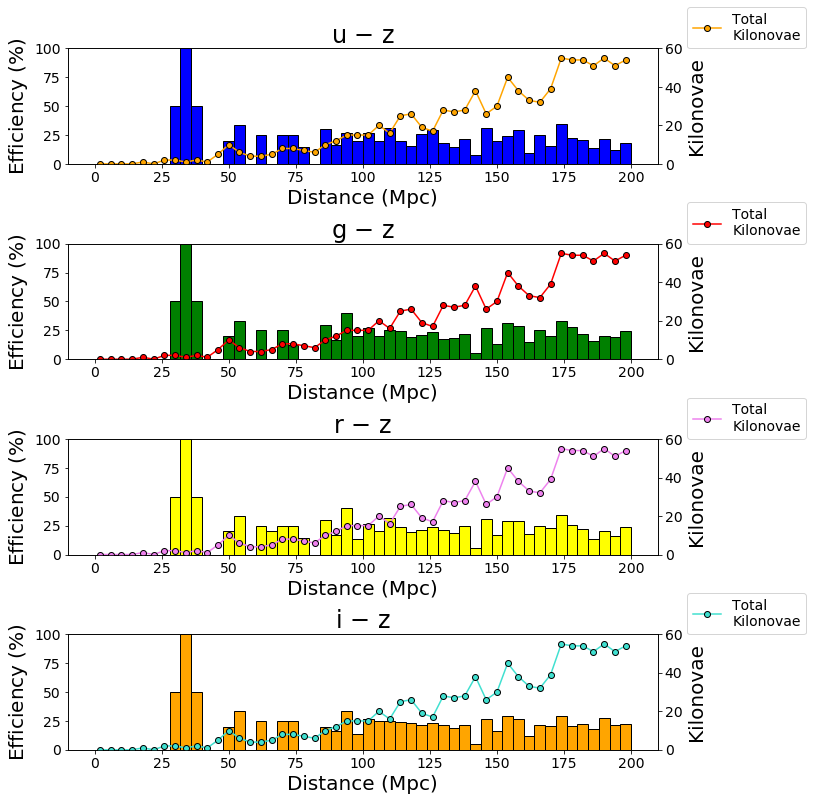

In [70]:
efficiency_plots(APR1215_table1).plot()

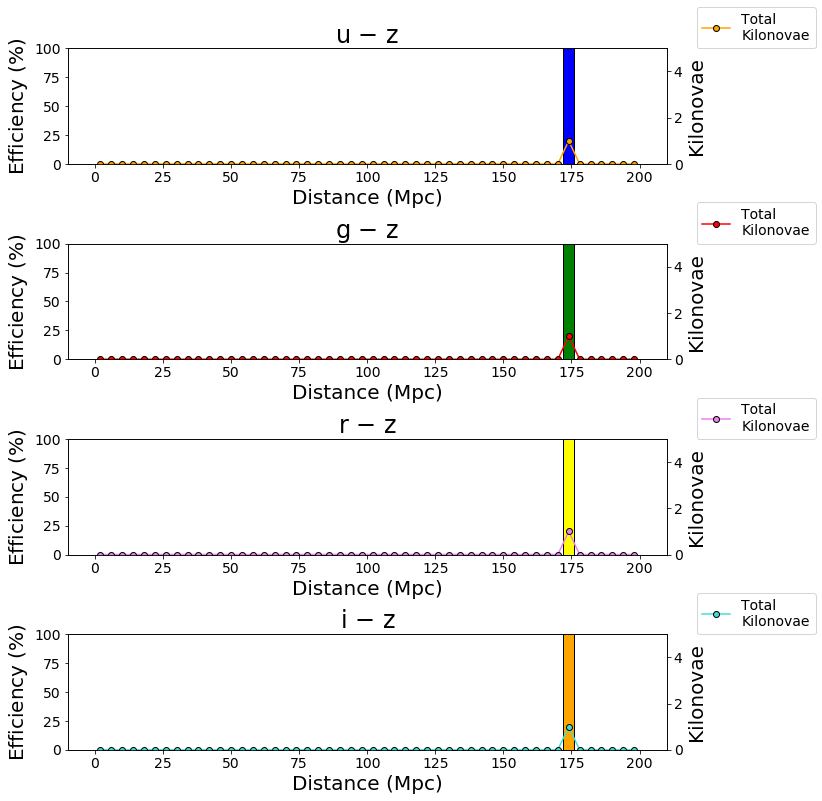

In [10]:
efficiency_plots(APR1215_table3).plot()

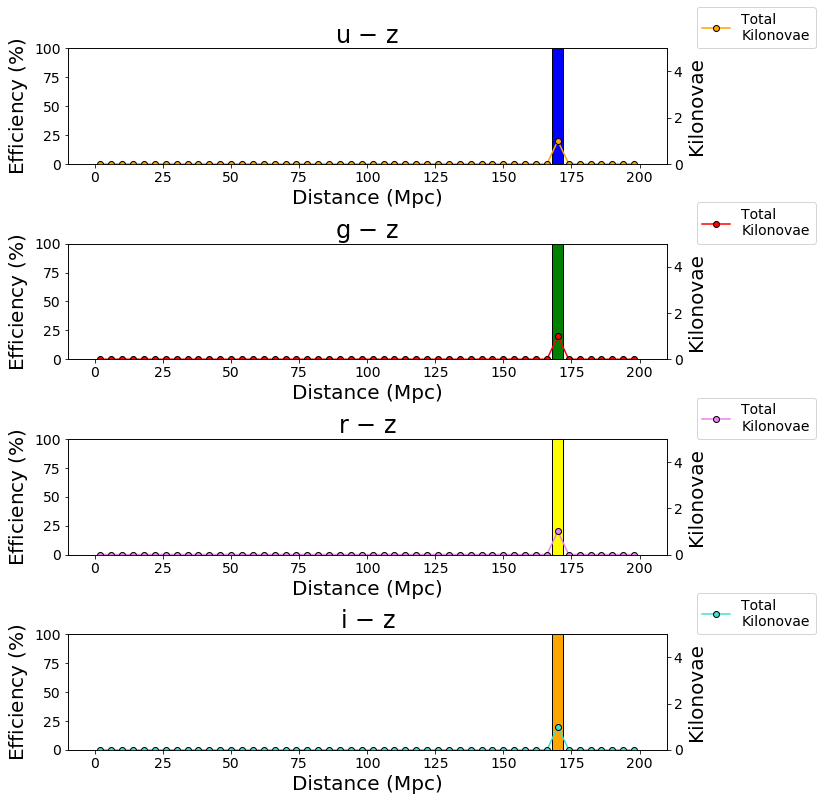

In [11]:
efficiency_plots(APR1215_table7).plot()

In [15]:
x = APR1215.app_mag_dist(40.7)

In [16]:
x.show_in_browser()

In [22]:
GW170817.app_mag_dist(40.7)

day,u,g,r,i,z
float64,float64,float64,float64,float64,float64
1.06,18.3017990921,17.4794853506,17.3809349233,17.3168544643,17.3125252155
1.57,19.7449784201,18.2651625317,17.8293431737,17.6495928588,17.4963602005
2.08,inf,19.0154429967,18.3550237435,18.0080193142,17.675379495
2.59,inf,19.6946155161,18.9897194489,18.2919050147,17.8401815948
3.1,inf,20.0576854311,19.2592332361,18.5549107384,17.9916889575
3.61,inf,20.6191740163,19.6338133447,18.8102294675,18.146312355
4.12,inf,20.9651406553,19.8557532952,19.0381890619,18.3049070549
4.63,inf,21.3537332186,20.2062076639,19.2796205843,18.4797239654
5.14,inf,21.5146226975,20.3648480219,19.5031246087,18.6808146137
